In [6]:
#!pip install xlrd

In [73]:
from funcoesTermosol import importa , plota
from math import sqrt
import numpy as np

# Definições:

# nn  : Número de nós
# N   : Matriz coordenada de nós
# nm  : Número de elementos
# Inc : Incidência
# nc  : Número de cargas
# F   : Forças
# nr  : Número de restrições
# R   : Matriz de restrições

[nn , N , nm , Inc , nc , F , nr , R] = importa('entrada.xlsx')

print(f" > Número de nós = {nn}");
print(f" > Matriz de Coordenasa de nós (x,y) = \n {N}");
print("\n")
print(f" > Número de elementos = {nm}");
print(f" > Matriz de Incidência (no1, no2 , E[Pa] , A[m²])= \n {Inc}");
print("\n")
print(f" > Número de cargas = {nc}");
print(f" > Vetor de Forças = \n {F}");
print("\n")
print(f" > Número de restrições = {nr}");
print(f" > Matriz de Restrições = \n {R}");

 > Número de nós = 3
 > Matriz de Coordenasa de nós (x,y) = 
 [[0.  0.  0.3]
 [0.  0.4 0.4]]


 > Número de elementos = 3
 > Matriz de Incidência (no1, no2 , E[Pa] , A[m²])= 
 [[1.0e+00 2.0e+00 2.1e+11 2.0e-04]
 [2.0e+00 3.0e+00 2.1e+11 2.0e-04]
 [3.0e+00 1.0e+00 2.1e+11 2.0e-04]]


 > Número de cargas = 2
 > Vetor de Forças = 
 [[   0.]
 [   0.]
 [   0.]
 [   0.]
 [ 150.]
 [-100.]]


 > Número de restrições = 3
 > Matriz de Restrições = 
 [[0.]
 [2.]
 [3.]]


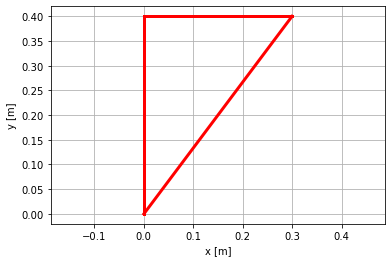

In [74]:
plota(N,Inc)

In [75]:
class Node:
    '''
    Classe representante de um nó.
    
    > id        : Identificador único
    > (x,y)     : Posicionamento no plano 2D
    > gl        : Graus de liberdade do no (em x, em y)
    > restricao : lista de restricao de movimento booleana (em x, em y) 
    
    '''
    
    def __init__(self , id , x , y):
        
        self.id = id
        self.x = x
        self.y = y
        
    def distance(self , node):
        return sqrt((node.x - self.x)**2 + (node.y - self.y)**2)
    
    def show_node(self):
        print(f" >> ID node: [{self.id}]")
        print(f" >> Coordenadas [x,y]: ({self.x},{self.y})")
        #print(f" >> Graus liberdade :  [{self.gl[0]},{self.gl[1]}]")
        #print(f" >> Restricao :  x ={self.restriction[0]} e y ={self.restriction[1]}")

In [76]:
class Element:
    '''
    Classe representante de um elemento barra simples
    
    node1 - Nó que forma elemento
    node2 - Nó que forma elemento 
    young_module  - Módulo de eleasticidade do elemento
    area - área transversal
    
    '''
    
    def __init__(self, id , node1 , node2 , young_module , area):
        
        self.id = id
        self.n1 = node1
        self.n2 = node2
        self.E  = young_module
        self.A  = area
         
    def length(self):
        '''
        Tamanho do elemento em metros
        '''
        return self.n1.distance(self.n2)
    
    def k(self):
        return (self.E*self.A)/self.length()
        
    def stiffness_matrix(self):
        '''
        Calcula matriz de rigidez do elemento
        '''
        
        s = (self.n2.y - self.n1.y)/self.length()
        c = (self.n2.x - self.n1.x)/self.length()
        
        matriz = np.array([[c**2 , c*s , -c**2 , -c*s],
                           [c*s , s**2, -c*s , -s**2],
                           [-c**2 , -c*s , c**2 , c*s],
                           [-c*s , -s**2 , c*s ,  s**2]])
        
        return ((self.E*self.A)/self.lengh())*matriz
        
    def show_element(self):
        print(f" >> ID : [{self.id}]")
        print(f" >> Young Module: {self.E}")
        print(f" >> Area: {self.A}")
        print(f" >> k = {self.k()}")
        print(f" >> l = {self.length()}")
        print("----------- nodes -----------")
        no1.show_node()
        no2.show_node()

In [77]:
matriz = np.zeros(shape=(len(N[0]), 2))
for i in range(0,len(N[0])):
    matriz[i][0] = N[0][i]
for  j in range(0, len(N[1])):
    matriz[j][1] = N[1][j]
    
matriz

array([[0. , 0. ],
       [0. , 0.4],
       [0.3, 0.4]])

In [78]:
# Define os 3 nós:

no1 = Node(1, N[0][0], N[0][1])
no2 = Node(2, N[0][2], N[1][0])
no3 = Node(3, N[1][1] , N[1][2])

no1.show_node()
no2.show_node()
no3.show_node()

 >> ID node: [1]
 >> Coordenadas [x,y]: (0.0,0.0)
 >> ID node: [2]
 >> Coordenadas [x,y]: (0.3,0.0)
 >> ID node: [3]
 >> Coordenadas [x,y]: (0.4,0.4)


In [79]:
# A cada 4 valores  de Inc tenho um elemento:
columns_info_inc = 4;

# A cada 2 valores de Coord tenho 1 nó:
columns_info_coord = 2;

In [80]:
# Cria elementos 1 e 2 :
list_elements  =[]


id_element = 1;
for linha in np.arange(nm):
    
    id_node1 = int(Inc[linha][0])
    id_node2 = int(Inc[linha][1])
    print(id_node1)
    print(id_node2)
    E = Inc[linha][2]
    A = Inc[linha][3]
    
    no1 = Node(id_node1 , matriz[id_node1-1][0], matriz[id_node1 - 1][1])

    no2 = Node(id_node2 , matriz[id_node2-1][0], matriz[id_node2-1][1])
    
    # Cria elemento:
    elemento = Element(id_element, no1, no2 , E , A)
    print(f"elemento {id_element} criado")
    elemento.show_element()
        
    id_element+=1; 
    

1
2
elemento 1 criado
 >> ID : [1]
 >> Young Module: 210000000000.0
 >> Area: 0.0002
 >> k = 105000000.0
 >> l = 0.4
----------- nodes -----------
 >> ID node: [1]
 >> Coordenadas [x,y]: (0.0,0.0)
 >> ID node: [2]
 >> Coordenadas [x,y]: (0.0,0.4)
2
3
elemento 2 criado
 >> ID : [2]
 >> Young Module: 210000000000.0
 >> Area: 0.0002
 >> k = 140000000.0
 >> l = 0.3
----------- nodes -----------
 >> ID node: [2]
 >> Coordenadas [x,y]: (0.0,0.4)
 >> ID node: [3]
 >> Coordenadas [x,y]: (0.3,0.4)
3
1
elemento 3 criado
 >> ID : [3]
 >> Young Module: 210000000000.0
 >> Area: 0.0002
 >> k = 84000000.0
 >> l = 0.5
----------- nodes -----------
 >> ID node: [3]
 >> Coordenadas [x,y]: (0.3,0.4)
 >> ID node: [1]
 >> Coordenadas [x,y]: (0.0,0.0)
